In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
import random

random.seed(10)

# Carga de datos

In [3]:
train_data = pd.read_csv("data/train_letters.csv")
test_data = pd.read_csv("data/validation_letters.csv")

In [4]:
train_data.head()

,sequence_id,target
0,2,h
1,3,i
2,4,e
3,5,a
4,6,g


# Analisis Exploratorio

In [5]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
train_letters = list(train_data.target.unique())
train_letters.sort()
print(f"Frases unicas : {train_letters}")

--------------------Train data--------------------
Cantidad de filas : 70
Frases unicas : ['a', 'b', 'c', 'e', 'g', 'h', 'i', 'k']


In [6]:
print("--------------------Validation data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
val_letters = list(test_data.target.unique())
val_letters.sort()
print(f"Frases unicas : {val_letters}")

--------------------Validation data--------------------
Cantidad de filas : 8
Frases unicas : ['a', 'b', 'c', 'e', 'g', 'h', 'i', 'k']


In [7]:
if (train_letters != val_letters):
    raise ValueError("Error between target and train")

In [8]:
train_data.describe()

,sequence_id
count,70.000000
mean,38.400000
std,22.071951
min,2.000000
25%,19.250000
50%,38.500000
75%,57.750000
max,78.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_Right_hand_{i}')
        cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [10]:
df = pd.read_csv("data/data_letters.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [11]:
df.head()

,sequence_id,target,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,...,x_Left_hand_16,y_Left_hand_16,x_Left_hand_17,y_Left_hand_17,x_Left_hand_18,y_Left_hand_18,x_Left_hand_19,y_Left_hand_19,x_Left_hand_20,y_Left_hand_20
0,1,e,0.804299,0.583940,0.750737,0.566927,0.714575,0.514373,0.716878,0.470309,...,0.804779,0.409903,0.849094,0.458599,0.861942,0.407896,0.851442,0.403257,0.840717,0.422747
1,2,h,0.464587,0.465854,0.447063,0.424897,0.451904,0.387954,0.470445,0.366979,...,0.497869,0.382714,0.515781,0.398205,0.520911,0.377737,0.515463,0.386400,0.510886,0.397761
2,3,i,0.624497,0.624226,0.679483,0.575228,0.689292,0.526482,0.664085,0.499805,...,0.586776,0.537653,0.571321,0.496291,0.553043,0.450049,0.541402,0.423654,0.535154,0.400292
3,4,e,0.353501,0.503693,0.400193,0.503756,0.435536,0.485880,0.452841,0.469905,...,0.381648,0.405732,0.352561,0.433539,0.346026,0.398931,0.356368,0.400270,0.362687,0.412075
4,5,a,0.411144,0.720415,0.430596,0.674462,0.437844,0.625611,0.432979,0.588692,...,0.424048,0.707385,0.393454,0.724980,0.442364,0.731001,0.433091,0.728897,0.417588,0.725050


In [12]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

78
True
True


# Modelo

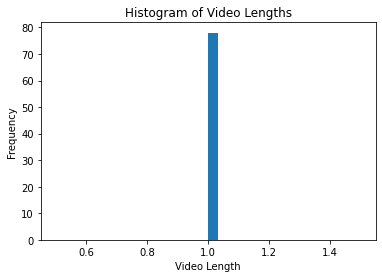

In [13]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [14]:
video_lengths.max()

1

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [16]:
def padding_videos(df):
    # Create a new DataFrame to store the filled rows
    filled_df = pd.DataFrame()
    target = []


    # Iterate over each group and fill remaining rows with zero
    for _, group in df.groupby('sequence_id'):
        remaining_rows = max_seq_length - len(group)
        zeros_df = pd.DataFrame([[0] * len(group.columns)] * remaining_rows, columns=group.columns)
        zeros_df['sequence_id'] = group['sequence_id'].unique()[0]
        zeros_df['target'] = group['target'].unique()[0]
        group = pd.concat([group, zeros_df])
    
        filled_df = filled_df.append(group)
        target.append(group["target"].unique()[0])
        
    filled_df.reset_index(drop=True, inplace=True)
    filled_df = filled_df.fillna(0)
    return filled_df, target

def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [17]:
X_train, target = padding_videos(df_train)
y_train = padding_labels(target)

In [18]:

del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

70 70


In [19]:
X_test, target = padding_videos(df_test)
y_test = padding_labels(target)
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

8 8


In [20]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

True

In [21]:
len(X_train)

70

In [22]:
# num_samples_train = int(len(X_train)/max_seq_length)
# num_features_train = len(get_needed_cols())
num_classes_train = len(y_train[1])

# X_train = X_train.values.reshape(num_samples_train, max_seq_length, num_features_train)

In [23]:
# X_train = flat_X(X_train)
# X_test = flat_X(X_test)

In [24]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (70, 42) (70, 8)
Test: (8, 42) (8, 8)


# Modelo
La entrada son las coordenadas de la mano que están relacionados en totalidad con la letra (target).

In [25]:
# Initialize Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [26]:
most_likely_predictions = np.argmax(y_pred, axis=1)
expected_labels = np.argmax(y_test, axis=1)

In [27]:
most_likely_predictions

array([3, 4, 0, 3, 6, 5, 7, 1], dtype=int64)

In [28]:
expected_labels

array([3, 4, 0, 2, 6, 5, 7, 1], dtype=int64)

In [29]:
predicted_labels = label_encoder.inverse_transform(most_likely_predictions)

In [30]:
expected_labels = label_encoder.inverse_transform(expected_labels)

In [31]:
correct = 0
for i in range(len(predicted_labels)):
    if (predicted_labels[i] == expected_labels[i]):
        correct += 1
        print("Correctamente predicha: ", predicted_labels[i])

Correctamente predicha:  e
Correctamente predicha:  g
Correctamente predicha:  a
Correctamente predicha:  i
Correctamente predicha:  h
Correctamente predicha:  k
Correctamente predicha:  b


In [32]:
print("Correct >> ", correct)
print("Expected >> ", len(test_data.target.unique()))
print("Ratio >> ", str(correct/len(test_data.target.unique())))

Correct >>  7
Expected >>  8
Ratio >>  0.875
